In [1]:
import importlib.util
def module_from_file(module_name, file_path): #The code that imports the file which originated the training with all the instructions
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            return module

from importlib import import_module
#foo = import_module(fold_folder+'/Funs.py', package=None)


folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4'
foo = module_from_file("foo", f'{folder}/Funs.py')

import random as rd  
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import log_loss

tff = foo.tff # tensorflow routines 
ut = foo.ut # utilities
ln = foo.ln #Learn2_new.py
print("==Checking GPU==")
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print("==Checking CUDA==")
tf.test.is_built_with_cuda()

#from tensorflow.keras.preprocessing.image import ImageDataGenerator
sys.path.insert(1, '../ERA')

print("==Reading data==")

year_permutation = np.load(f'{folder}/year_permutation.npy')

2022-07-11 17:27:39.805388: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
==Checking GPU==
==Checking CUDA==
==Reading data==


2022-07-11 17:27:45.748056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-11 17:27:46.169223: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-11 17:27:46.169327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r815cores48): /proc/driver/nvidia/version does not exist
2022-07-11 17:27:46.169359: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 17:27:46.173341: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [2]:
run_vae_kwargs = ut.json2dict(f"{folder}/config.json")
T = ut.extract_nested(run_vae_kwargs, 'T')
if (ut.keys_exists(run_vae_kwargs, 'label_period_start') and ut.keys_exists(run_vae_kwargs, 'label_period_end')):
    label_period_start = ut.extract_nested(run_vae_kwargs, 'label_period_start')
    label_period_end = ut.extract_nested(run_vae_kwargs, 'label_period_end')
    time_start = ut.extract_nested(run_vae_kwargs, 'time_start')
    time_end = ut.extract_nested(run_vae_kwargs, 'time_end')

In [29]:
n_days = time_end-time_start-T+1
n_days

105

In [4]:
import pickle
fold = 0
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10

analogues['ind_new_tr'][checkpoint]//n_days

array([[  0, 241,   0, ..., 351,   3,  52],
       [  0,   0,  54, ..., 102, 145, 176],
       [  0,   0, 405, ..., 390, 251, 378],
       ...,
       [449,  99,  99, ...,  74, 255, 123],
       [281, 177, 241, ..., 208, 313, 198],
       [208, 241, 211, ..., 376, 209, 339]])

In [5]:
import numpy as np
#selfanalogues = (analogues['ind_new_tr'][checkpoint]//n_days)[:,0][np.newaxis].T
selfanalogues = ((np.arange(analogues['ind_new_tr'][checkpoint].shape[0]//n_days)[np.newaxis].T*np.ones((analogues['ind_new_tr'][checkpoint].shape[0]//n_days,n_days))).astype(int)).flatten()[np.newaxis].T # This is a matrix of years related to the raw index
#selfanalogues*np.ones((selfanalogues.shape[0],analogues['ind_new_tr'][checkpoint].shape[1]))
sameyear = selfanalogues*np.ones((selfanalogues.shape[0],analogues['ind_new_tr'][checkpoint].shape[1]))==analogues['ind_new_tr'][checkpoint]//n_days # A conditional matrix showing if the entry belongs to the same year 
#sameyear
noselfanalogs = (np.where(sameyear,-1,analogues['ind_new_tr'][checkpoint])) # We set to -1 all the entries that are analogs of the same year
print(np.mean(noselfanalogs == -1))
noselfanalogs

0.011160084656084656


array([[   -1, 25317,    -1, ..., 36866,   363,  5498],
       [   -1,    -1,  5699, ..., 10810, 15256, 18567],
       [   -1,    -1, 42545, ..., 41037, 26448, 39714],
       ...,
       [   -1, 10439, 10440, ...,  7836, 26834, 13010],
       [29575, 18631, 25326, ..., 21915, 32889, 20820],
       [21921, 25326, 22243, ..., 39553, 21970, 35628]])

In [6]:
noselfanalogsmoved = []
for noselfanalogs_row in noselfanalogs: # loop over samples
    temp = np.delete(noselfanalogs_row,noselfanalogs_row==-1) # remove the values equal to -1 
    noselfanalogsmoved.append(np.pad(temp, (0,noselfanalogs_row.shape[0] - temp.shape[0]), constant_values=(noselfanalogs.shape[0],noselfanalogs.shape[0])))  # pad with the length of the time series so that if we accidently get such analog the error will be returned
noselfanalogsmoved = np.array(noselfanalogsmoved)
noselfanalogsmoved

array([[25317, 25055, 10706, ..., 47250, 47250, 47250],
       [ 5699, 42841,  5701, ..., 47250, 47250, 47250],
       [42545,  5363,  5365, ..., 47250, 47250, 47250],
       ...,
       [10439, 10440, 26960, ..., 47250, 47250, 47250],
       [29575, 18631, 25326, ..., 20820, 47250, 47250],
       [21921, 25326, 22243, ..., 39553, 21970, 35628]])

In [7]:
analogues['ind_new_va'][checkpoint].shape

(5250, 1000)

In [10]:
import numba as nb
from numba import jit,guvectorize,set_num_threads

num_Traj = 10000 #number of trajectories for monte-carlo sampling of committor
Matr_tr = noselfanalogsmoved
Matr_va = analogues['ind_new_va'][checkpoint]
delay = np.arange(6) # Here we make it indices rather than steps #np.array([0,3,6,9,12,15])  #time prediction (what we call lead time tau)
chain_step = 3 # step of a Markov chain
N_Steps = T//chain_step
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")
neighbors = [10]

threshold = np.array([2.742728328704834]) #Threshold defining committor. This parameter I don't need, I shall perhaps transform it into epochs for variational autoencoder

step_Traj = 5  #number of steps in the markov chain for 15 days.
#Function for computing the committor at one point. Input: day=point where committor is computed (state of markov chain), ther= vector of threshold, dela= vector of delays, nn= number of neighbors, Matr=Matix which contains indeces of Markov chain, res= vector where results are stored
@guvectorize([(nb.int64,nb.float64[:],nb.int64[:],nb.float64[:],nb.float64[:],nb.int64,nb.int64,nb.int64,nb.int64,nb.int64[:,:],nb.int64[:,:],nb.float64[:,:])],'(),(n),(m),(p),(q),(),(),(),(),(k,o),(l,j)->(n,m)',nopython=True,target="parallel")
def CommOnePoint(day,ther,dela, Temp_va, Temp_tr, nn, n_Traj, numsteps, Markov_step, Matr_va, Matr_tr,res): # a day implies the temporal coordinates in days of the input from the 0-th year of the 1000 year long dataset
    wrong_index = 0 # This checks that during input or execution we were always working with indecies that exist in the considered matrices and we don't go below or above
    if (day >= Matr_va.shape[0]) or (day < 0): # We don't allow inputs that are outside of the range of Matr_va. 
        #print("day > Matr_va.shape[0]")
        wrong_index = 1 # manual debugging (unfortunately numba does not capture this)
        print("We don't allow inputs that are outside of the range of Matr_va")
        for l_1 in range(len(ther)):
            for l_2 in range(len(dela)):
                res[l_1][l_2] = np.nan # we simply  don't have corresponding index
    if nn > Matr_va.shape[1]:
        wrong_index = 1 # manual debugging
        print("We don't allow inputs that are outside of the range of Matr_va")
    else:
        #print("day <= Matr_va.shape[0]")
        z = np.zeros((len(ther),len(dela))) #auxiliary variable (result)
        for i in range(n_Traj):
            app = rd.randint(0,nn-1) # we go randomly to the training dataset from the validation dataset without updating the time
            s = Matr_va[day][app]
            #print("output: ", day,app,s, Matr_va.shape)
            if (s >= Matr_tr.shape[0]) or (s < 0):
                wrong_index = 1
            A = np.zeros((len(ther),len(dela))) #auxiliary variable (integrated temperature)
            
            for j in range(numsteps+np.max(dela)): 
                if j > 0: # We take the j = 0 case as the initial analog and evolve only the later ones
                    app = rd.randint(0,nn-1) #analogue selection
                    s = Matr_tr[s][app] + Markov_step         #analog state s is evolved in time
                    if (s >= Matr_tr.shape[0]) or (s < 0):
                        wrong_index = 1
                    if nn > Matr_tr.shape[1]:
                        wrong_index = 1 # manual debugging
                for l_2 in range(len(dela)): 
                    if(j>=dela[l_2] and j<dela[l_2]+numsteps):
                        for l_1 in range(len(ther)):
                            if j > 0: # We take the j = 0 case as the initial state which is already known
                                if (s >= len(Temp_tr)) or (s < 0):
                                    wrong_index = 1
                                else:
                                    A[l_1][l_2] += Temp_tr[s] ## GM: we start counting A only when we get into this delay window
                            else: # We take the j = 0 case as the initial state which is already known. That state is 'day' in validation set
                                if (day >= len(Temp_va)) or (day < 0):
                                    wrong_index = 1
                                else:
                                    A[l_1][l_2] += Temp_va[day] ## GM: we start counting A only when we get into this delay window
            A = A / numsteps 
            
            #Check if A>a
            for l_1 in range(len(ther)):
                for l_2 in range(len(dela)):
                    if(A[l_1][l_2]>ther[l_1]):
                        z[l_1][l_2] += 1.
        if wrong_index == 0:
            #fill res vector
            for l_1 in range(len(ther)):
                for l_2 in range(len(dela)):
                    res[l_1][l_2] = z[l_1][l_2] / n_Traj
        else:
            print("Somewhere inside the code there was an input outside of the range of matrices/vectors")
            for l_1 in range(len(ther)):
                for l_2 in range(len(dela)):
                    res[l_1][l_2] = np.nan # we simply  don't have the corresponding index

In [11]:
print(f"{len(time_series_va) = } ,{len(time_series_tr) = } ,{Matr_va.shape = } ,{Matr_tr.shape = }")
nn = neighbors[0]
q_1 = CommOnePoint(33,threshold,delay,time_series_va[:,0],time_series_tr[:,0],nn,10000, N_Steps, chain_step, Matr_va,Matr_tr)
print(q_1)

len(time_series_va) = 5250 ,len(time_series_tr) = 47250 ,Matr_va.shape = (5250, 1000) ,Matr_tr.shape = (47250, 1000)
[[0.5072 0.2451 0.1302 0.0891 0.0689 0.0575]]


In [13]:
days =  np.arange(4)
q_1 = CommOnePoint(days,threshold,delay,time_series_va[:,0],time_series_tr[:,0],nn,10000, N_Steps, chain_step, Matr_va,Matr_tr)
#print(y*90+89)
print(q_1)
print(q_1.reshape(2,2,6))

[[[0.2973 0.1122 0.0648 0.0436 0.038  0.0353]]

 [[0.1378 0.0509 0.0375 0.0372 0.0394 0.0396]]

 [[0.1246 0.0523 0.0354 0.0332 0.0346 0.0351]]

 [[0.1288 0.0568 0.0377 0.0349 0.0398 0.0432]]]
[[[0.2973 0.1122 0.0648 0.0436 0.038  0.0353]
  [0.1378 0.0509 0.0375 0.0372 0.0394 0.0396]]

 [[0.1246 0.0523 0.0354 0.0332 0.0346 0.0351]
  [0.1288 0.0568 0.0377 0.0349 0.0398 0.0432]]]


In [14]:
days =  np.arange(Matr_va.shape[0])
q = CommOnePoint(days,threshold,delay,time_series_va[:,0],time_series_tr[:,0],20,10000, N_Steps, chain_step, Matr_va,Matr_tr)
#print(y*90+89)
print(q.shape)
print(q[0,0,0])
print(q.reshape(-1,n_days,len(delay)).shape)
q = q.reshape(-1,n_days,len(delay))

(5250, 1, 6)
0.2444
(50, 105, 6)


In [15]:
q_tau = np.zeros((q.shape[0],n_days-T+1 - label_period_start+time_start,q.shape[2]))
for dela in delay:
    q_tau[...,dela] = (q[...,dela][:,(label_period_start-time_start-dela*chain_step):(n_days-T+1-dela*chain_step)])
    print(dela, q_tau[0,0,dela])
    
Y_va = np.load(f"{folder}/fold_{fold}/Y_va.npy")
Y_va = Y_va.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
q_tau.shape, Y_va.shape

0 0.4636
1 0.0831
2 0.018
3 0.0291
4 0.041
5 0.0401


((50, 76, 6), (50, 76))

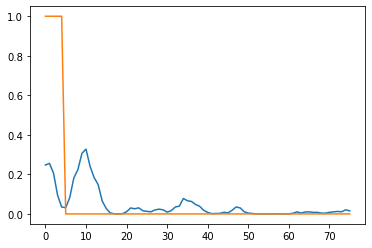

In [16]:
import matplotlib.pyplot as plt
plt.plot(q_tau[10,:,0])
plt.plot(Y_va[10,:])

In [19]:
#days = np.array(range(y*n_days,(y+100)*n_days))
days =  np.array([-1,Matr_va.shape[0]-1,Matr_va.shape[0]+3])
print(f"{days = }")
q = CommOnePoint(days,threshold,delay,time_series_va[:,0],time_series_tr[:,0],nn,100, N_Steps, chain_step, Matr_va,Matr_tr)
#print(y*90+89)
print(q)

days = array([  -1, 5249, 5253])
We don't allow inputs that are outside of the range of Matr_vaWe don't allow inputs that are outside of the range of Matr_va

Somewhere inside the code there was an input outside of the range of matrices/vectors
Somewhere inside the code there was an input outside of the range of matrices/vectors
[[[ nan  nan  nan  nan  nan  nan]]

 [[0.03 0.07 0.07 0.07 0.06 0.07]]

 [[ nan  nan  nan  nan  nan  nan]]]


Here we are testing what happens when starting from the training set without removing self-analogs and using only one analog (or itself). We expect in this case the committor to deterministically collapse to the ground truth. To get the training labels we take the validation labels of the next fold

In [20]:
fold = 0
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10
Matr_va = analogues['ind_new_va'][checkpoint]
Matr_tr = analogues['ind_new_tr'][checkpoint]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")

days =  np.arange(Matr_va.shape[0])
q = CommOnePoint(days,threshold,delay,time_series_tr[:,0],time_series_tr[:,0],1,10000, N_Steps, chain_step, Matr_tr,Matr_tr)
print(q.shape)
print(q[0,0,0])
print(q.reshape(-1,n_days,len(delay)).shape)
q = q.reshape(-1,n_days,len(delay))

q_tau = np.zeros((q.shape[0],n_days-T+1 - label_period_start+time_start,q.shape[2]))
for dela in delay:
    q_tau[...,dela] = (q[...,dela][:,(label_period_start-time_start-dela*chain_step):(n_days-T+1-dela*chain_step)])
    print(dela, q_tau[0,0,dela])
    
Y_va1 = np.load(f"{folder}/fold_1/Y_va.npy")
Y_va1 = Y_va1.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
q_tau[2,:,0], Y_va1[2,:], Y_va1[2,:]-q_tau[2,:,0]

(5250, 1, 6)
1.0
(50, 105, 6)
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0


(array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

In [21]:
fold = 0
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10
Matr_va = analogues['ind_new_va'][checkpoint]
Matr_tr = analogues['ind_new_tr'][checkpoint]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")

days =  np.arange(Matr_va.shape[0],2*Matr_va.shape[0])
q = CommOnePoint(days,threshold,delay,time_series_tr[:,0],time_series_tr[:,0],1,10000, N_Steps, chain_step, Matr_tr,Matr_tr)
print(q.shape)
print(q[0,0,0])
print(q.reshape(-1,n_days,len(delay)).shape)
q = q.reshape(-1,n_days,len(delay))

q_tau = np.zeros((q.shape[0],n_days-T+1 - label_period_start+time_start,q.shape[2]))
for dela in delay:
    q_tau[...,dela] = (q[...,dela][:,(label_period_start-time_start-dela*chain_step):(n_days-T+1-dela*chain_step)])
    print(dela, q_tau[0,0,dela])
    
Y_va2 = np.load(f"{folder}/fold_2/Y_va.npy")
Y_va2 = Y_va2.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
q_tau[2,:,0], Y_va2[2,:], Y_va2[2,:]-q_tau[2,:,0]

(5250, 1, 6)
1.0
(50, 105, 6)
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

In [22]:
fold = 1
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10
Matr_va = analogues['ind_new_va'][checkpoint]
Matr_tr = analogues['ind_new_tr'][checkpoint]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")

days =  np.arange(Matr_va.shape[0])
q = CommOnePoint(days,threshold,delay,time_series_tr[:,0],time_series_tr[:,0],1,10000, N_Steps, chain_step, Matr_tr,Matr_tr)
print(q.shape)
print(q[0,0,0])
print(q.reshape(-1,n_days,len(delay)).shape)
q = q.reshape(-1,n_days,len(delay))

q_tau = np.zeros((q.shape[0],n_days-T+1 - label_period_start+time_start,q.shape[2]))
for dela in delay:
    q_tau[...,dela] = (q[...,dela][:,(label_period_start-time_start-dela*chain_step):(n_days-T+1-dela*chain_step)])
    print(dela, q_tau[0,0,dela])
    
Y_va0 = np.load(f"{folder}/fold_0/Y_va.npy")
Y_va0 = Y_va0.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
q_tau.shape, Y_va0.shape
q_tau[2,:,0], Y_va0[2,:], Y_va0[2,:]-q_tau[2,:,0]

(5250, 1, 6)
1.0
(50, 105, 6)
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 1.]),
 array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,
         0.,  0.,  0.,  0.,

In [23]:
q_tau[2,:,0], Y_va2[2,:], Y_va2[2,:]-q_tau[2,:,0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

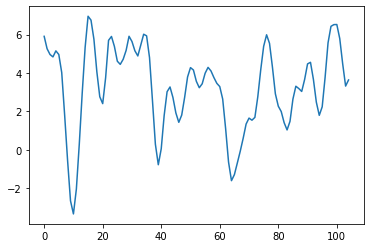

In [24]:
plt.plot(np.load(f"{folder}/fold_{0}/time_series_va.npy").reshape(-1,n_days,3)[0,:,0])

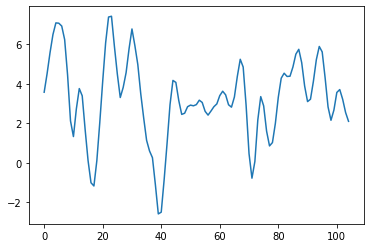

In [25]:
plt.plot(np.load(f"{folder}/fold_{0}/time_series_tr.npy").reshape(-1,n_days,3)[0,:,0])

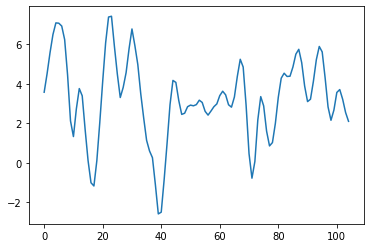

In [26]:
plt.plot(np.load(f"{folder}/fold_{1}/time_series_va.npy").reshape(-1,n_days,3)[0,:,0])

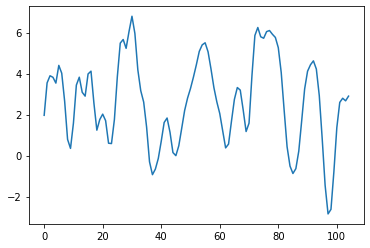

In [27]:
plt.plot(np.load(f"{folder}/fold_{1}/time_series_tr.npy").reshape(-1,n_days,3)[0,:,0])

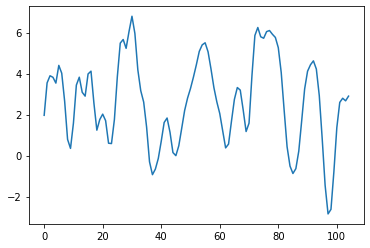

In [28]:
plt.plot(np.load(f"{folder}/fold_{2}/time_series_va.npy").reshape(-1,n_days,3)[0,:,0])

In [31]:
fold = 1
open_file = open(f'{folder}/fold_{fold}/analogues.pkl', "rb")
analogues = pickle.load(open_file)
open_file.close()

checkpoint = 10
Matr_va = analogues['ind_new_va'][checkpoint]
Matr_tr = analogues['ind_new_tr'][checkpoint]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")

days =  np.arange(Matr_va.shape[0],2*Matr_va.shape[0])
q = CommOnePoint(days,threshold,delay,time_series_tr[:,0],time_series_tr[:,0],1,10000, N_Steps, chain_step, Matr_tr,Matr_tr)
print(q.shape)
print(q[0,0,0])
print(q.reshape(-1,n_days,len(delay)).shape)
q = q.reshape(-1,n_days,len(delay))

q_tau = np.zeros((q.shape[0],n_days-T+1 - label_period_start+time_start,q.shape[2]))
for dela in delay:
    q_tau[...,dela] = (q[...,dela][:,(label_period_start-time_start-dela*chain_step):(n_days-T+1-dela*chain_step)])
    print(dela, q_tau[0,0,dela])
    
Y_va3 = np.load(f"{folder}/fold_3/Y_va.npy")
Y_va3 = Y_va3.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
q_tau.shape, Y_va3.shape

(5250, 1, 6)
0.0
(50, 105, 6)
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0


((50, 76, 6), (50, 76))

In [32]:
q_tau[2,:,0], Y_va3[2,:], Y_va3[2,:]-q_tau[2,:,0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

Since trajectory is now deterministic

In [34]:
q_tau[2,:,5], Y_va3[2,:], Y_va3[2,:]-q_tau[2,:,5]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]))

In [13]:
import numba as nb
from numba import jit,guvectorize,set_num_threads

n_Traj = range(10000) #number of trajectories for monte-carlo sampling of committor
Matr_tr = noselfanalogsmoved
Matr_va = analogues['ind_new_va'][checkpoint]
nsteps = np.arange(10) # Here we make it indices rather than steps #np.array([0,3,6,9,12,15])  #time prediction (what we call lead time tau)
chain_step = 3 # step of a Markov chain
N_Steps = T//chain_step
neighbors = [10]
time_series_tr = np.load(f"{folder}/fold_{fold}/time_series_tr.npy")
time_series_va = np.load(f"{folder}/fold_{fold}/time_series_va.npy")
threshold = np.array([2.742728328704834]) #Threshold defining committor. This parameter I don't need, I shall perhaps transform it into epochs for variational autoencoder

@guvectorize([(nb.int64,nb.int64[:],nb.int64[:],nb.int64,nb.int64,nb.int64[:,:],nb.int64[:,:],nb.float64[:,:])],'(),(n),(m),(),(),(k,o),(l,j)->(n,m)',nopython=True,target="parallel")
def SampleTraj(day,n_Traj,nsteps, nn, Markov_step, Matr_va, Matr_tr,res): # a day implies the temporal coordinates in days of the input from the 0-th year of the 1000 year long dataset
    wrong_index = 0 # This checks that during input or execution we were always working with indecies that exist in the considered matrices and we don't go below or above
    if (day >= Matr_va.shape[0]) or (day < 0): # We don't allow inputs that are outside of the range of Matr_va. 
        #print("day > Matr_va.shape[0]")
        wrong_index = 1 # manual debugging (unfortunately numba does not capture this)
        print("We don't allow inputs that are outside of the range of Matr_va")
        for l_1 in range(len(n_Traj)):
            for l_2 in range(len(nsteps)):
                res[l_1][l_2] = np.nan # we simply  don't have corresponding index
    if nn > Matr_va.shape[1]:
        wrong_index = 1 # manual debugging
        print("We don't allow inputs that are outside of the range of Matr_va")
    else:
        #print("day <= Matr_va.shape[0]")
        s_traj = np.zeros((len(n_Traj),len(nsteps))) #auxiliary variable (result)
        for l_1 in range(len(n_Traj)):
            app = rd.randint(0,nn-1) # we go randomly to the training dataset from the validation dataset without updating the time
            s = Matr_va[day][app]
            
            #print("output: ", day,app,s, Matr_va.shape)
            if (s >= Matr_tr.shape[0]) or (s < 0):
                wrong_index = 1
            for l_2 in range(len(nsteps)): 
                app = rd.randint(0,nn-1) #analogue selection
                s = Matr_tr[s][app] + Markov_step         #analog state s is evolved in time
                s_traj[l_1][l_2] = s
                if (s >= Matr_tr.shape[0]) or (s < 0):
                    wrong_index = 1
                    print("We don't allow s that are outside of the range of Matr_tr")
                if nn > Matr_tr.shape[1]:
                    wrong_index = 1 # manual debugging
                    print("We don't allow nn that are outside of the range of Matr_tr")
        #print("wrong index = ", wrong_index)
        for l_1 in range(len(n_Traj)):
            for l_2 in range(len(nsteps)):
                res[l_1][l_2] = s_traj[l_1][l_2] 

In [43]:
time_series_tr[:,0]

array([ 3.579894  ,  4.519636  ,  5.5803432 , ...,  0.02219056,
       -1.21639   , -2.130549  ], dtype=float32)

In [26]:
nn = neighbors[0]
trajs = (SampleTraj(range(Matr_va.shape[0]),range(10000),range(10), nn, chain_step, Matr_va,Matr_tr)).astype(int)
trajs.shape

(5250, 10000, 10)

In [32]:
trajs[0,:,:]%n_days

array([[ 32,  41,  94, ...,  16,  48,  46],
       [ 99,  89,  50, ...,  36,  58,  76],
       [ 99,  13,  57, ..., 101,  42,  51],
       ...,
       [  9,  10,  13, ...,  39,  55,  82],
       [ 25,  80,  56, ...,  12,  36,  45],
       [ 78,  44,  64, ...,  47,  66,  30]])

In [33]:
trajs[0,:,:]

array([[22292, 41306,  5029, ..., 22381, 26613, 21676],
       [ 5034, 31169, 17585, ..., 31116, 17698, 40816],
       [ 5034, 30463, 40902, ..., 25511,  8967,  9606],
       ...,
       [  429, 27625, 33088, ...,  2454,  2680,  6907],
       [34150, 27170,   266, ..., 42117,  5706, 21570],
       [ 1233, 29654, 44374, ..., 22097, 25161, 45705]])

In [44]:
np.std(time_series_tr[trajs[0,:,:],0],0)

array([2.173412 , 2.7361765, 2.4530544, 2.356952 , 2.329642 , 2.2853644,
       2.3011267, 2.2733982, 2.2500465, 2.2556977], dtype=float32)

Ok, if the variance does not decrease why do we observe that the probability of the heatwave estimated by the analog method goes down with tau?

In [4]:
import numpy as np
import pickle
folder = './xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/'
open_file = open(f'{folder}/committor10000.pkl', "rb")
committor_dictionary = pickle.load(open_file)
open_file.close()
committor = committor_dictionary['committor']
Y = np.load('./xforanalogs/NA24by48/Z8/yrs500/interT15fw20.1.20lrs4/Y.npy')

2022-07-11 15:42:02.089809: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 15:42:02.090608: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
committor.keys(),committor[10].keys(),committor[10][20].keys()

(dict_keys([1, 5, 10, 100, 1000]),
 dict_keys([1, 2, 3, 5, 10, 20, 50, 100, 200, 300]),
 dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

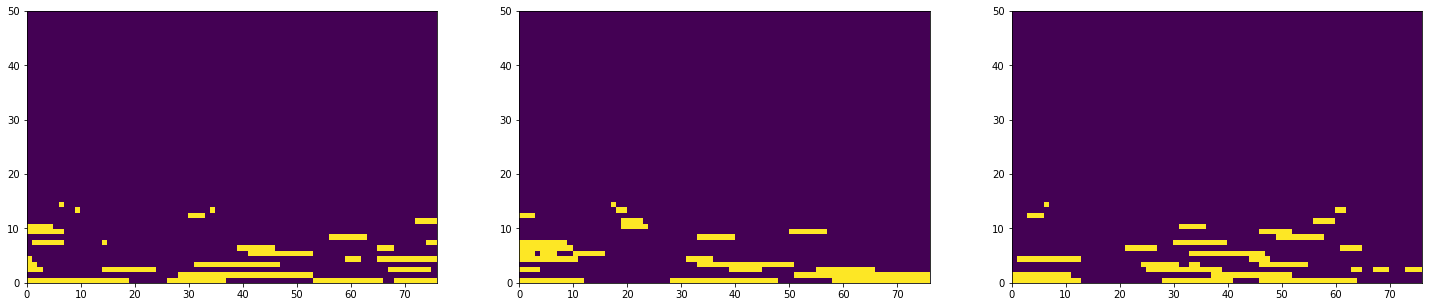

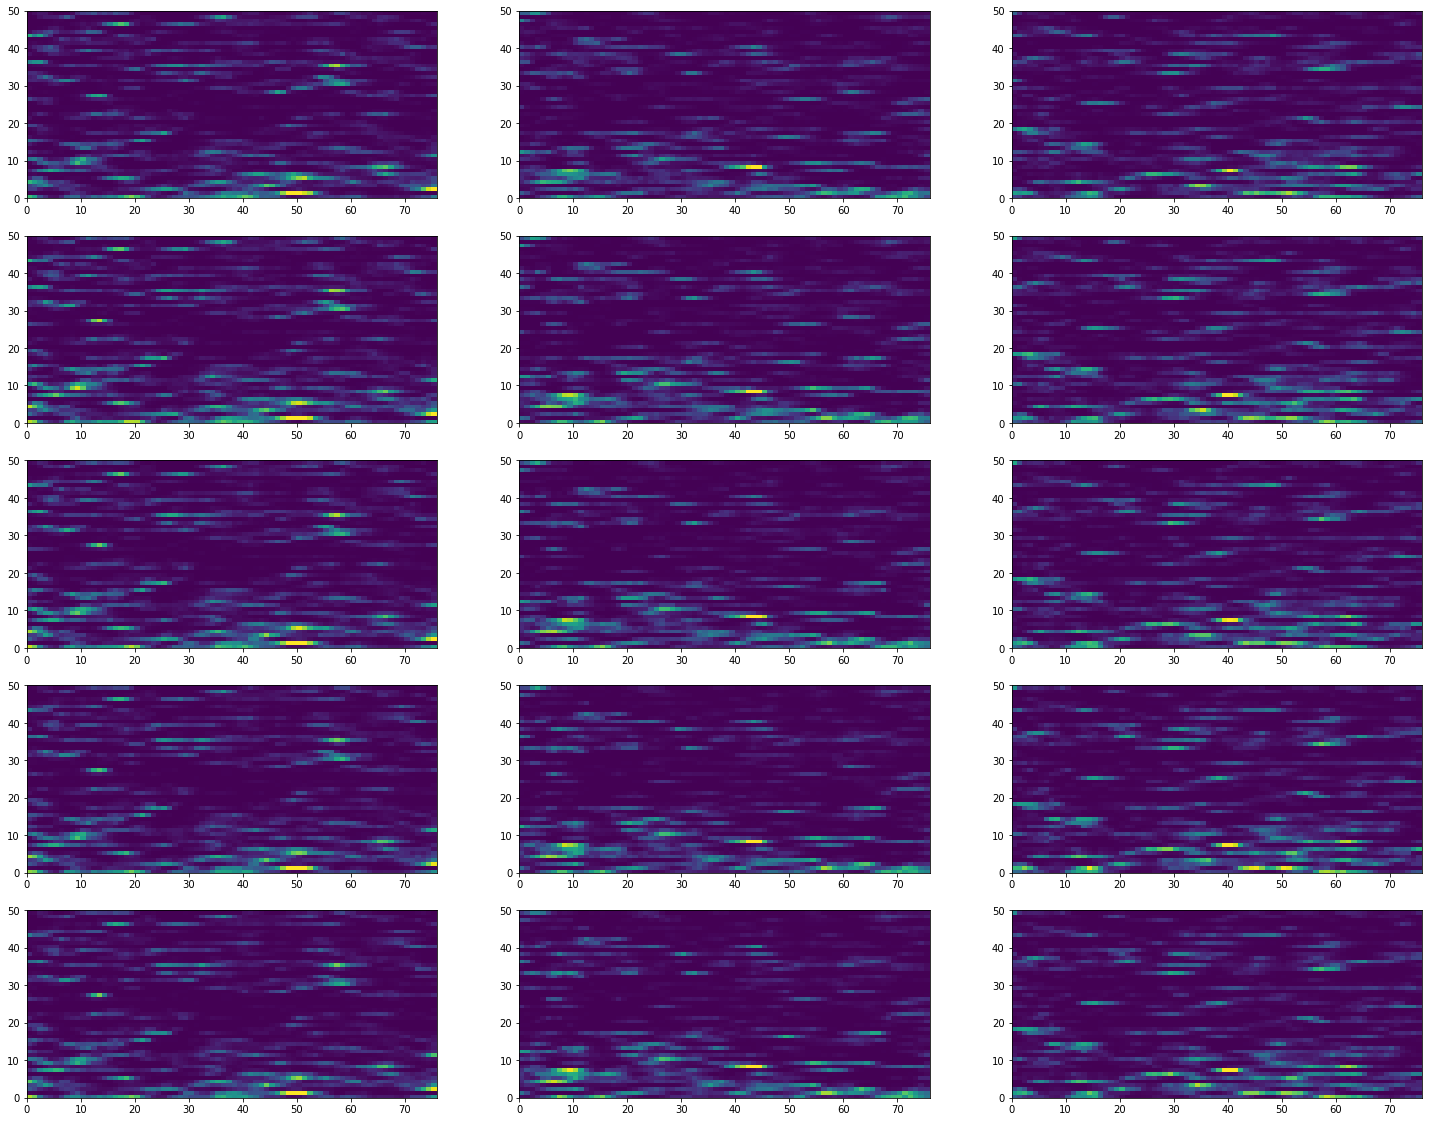

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(25, 5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
for fold in range(3):
        Y_va = np.load(f'{folder}/fold_{fold}/Y_va.npy')
        Y_va = Y_va.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
        ax = fig.add_subplot(spec[0,fold])
        ax.pcolor(Y_va, vmin=0, vmax=1)

nn = 50
tau = 0
fig2 = plt.figure(figsize=(25, 20))
spec2 = gridspec.GridSpec(ncols=3, nrows=len(list(committor.keys())), figure=fig2)
for i,checkpoint in enumerate(list(committor.keys())):
        for fold in range(3):
                q = committor[checkpoint][nn][fold]
                q = q.reshape(-1,n_days,q.shape[1])[:,(label_period_start-time_start-3*tau):(n_days-T+1-3*tau),tau]
                ax = fig2.add_subplot(spec2[i,fold])
                ax.pcolor(q, vmin=0, vmax=.5)

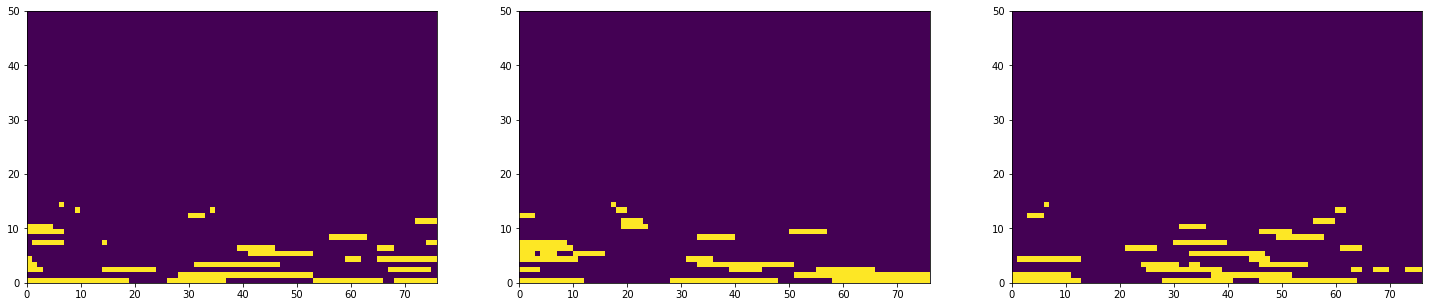

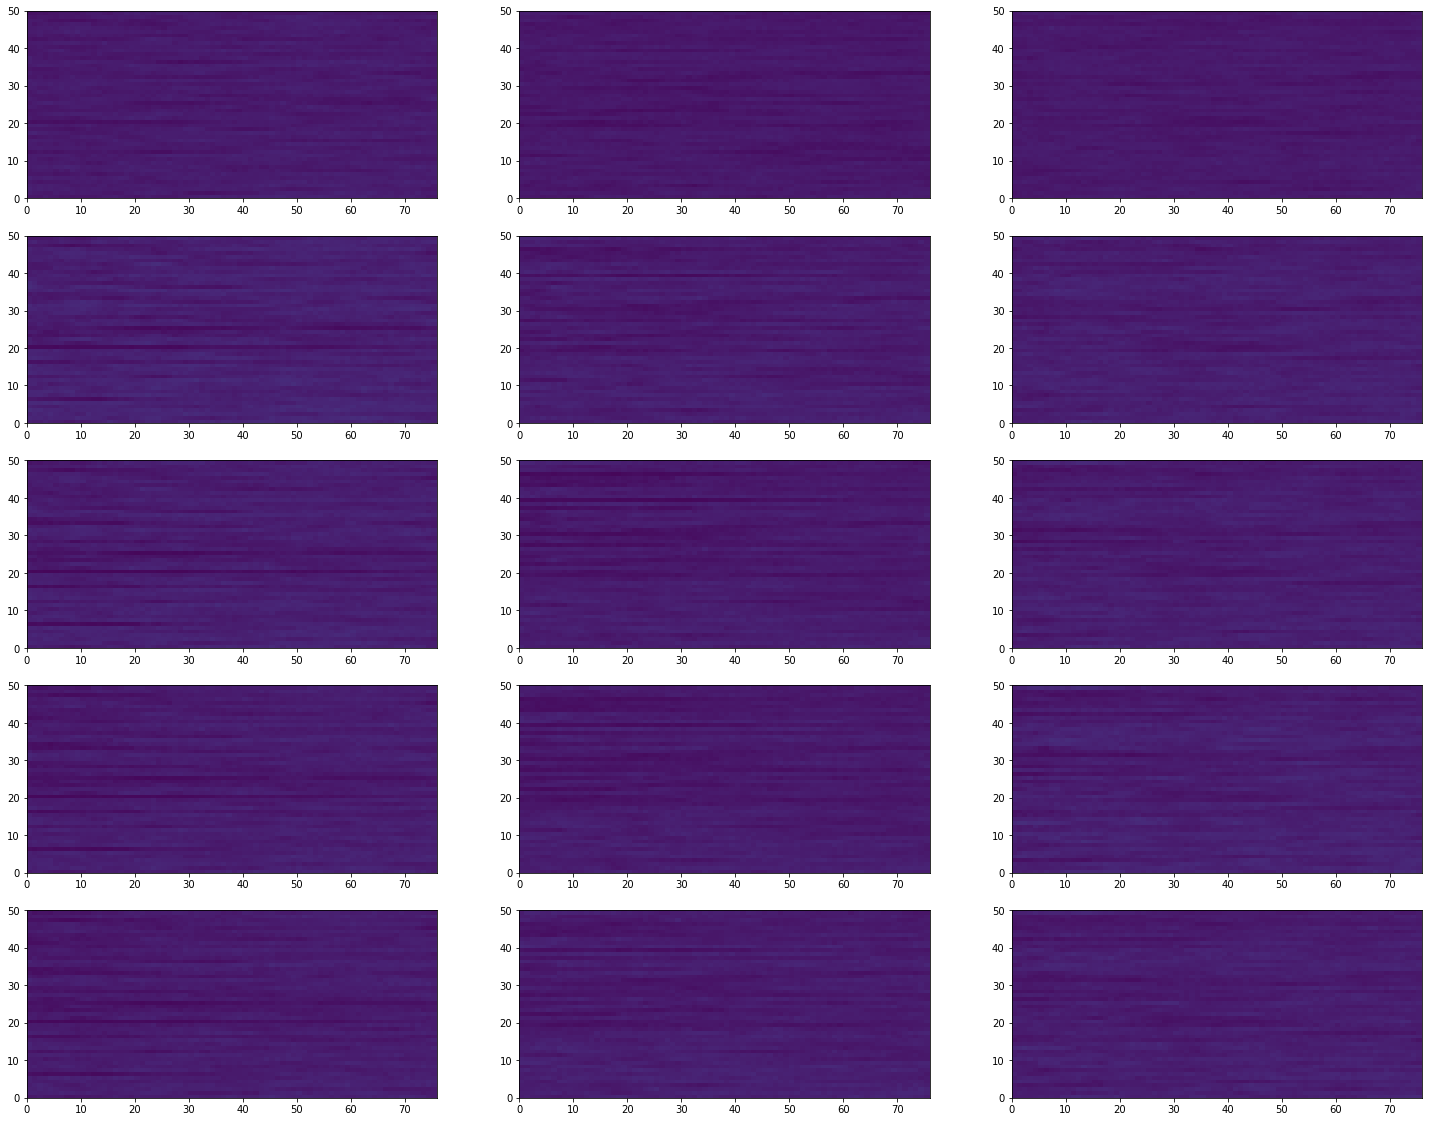

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(25, 5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
for fold in range(3):
        Y_va = np.load(f'{folder}/fold_{fold}/Y_va.npy')
        Y_va = Y_va.reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]
        ax = fig.add_subplot(spec[0,fold])
        ax.pcolor(Y_va, vmin=0, vmax=1)

nn = 50
tau = 5
fig2 = plt.figure(figsize=(25, 20))
spec2 = gridspec.GridSpec(ncols=3, nrows=len(list(committor.keys())), figure=fig2)
for i,checkpoint in enumerate(list(committor.keys())):
        for fold in range(3):
                q = committor[checkpoint][nn][fold]
                q = q.reshape(-1,n_days,q.shape[1])[:,(label_period_start-time_start-3*tau):(n_days-T+1-3*tau),tau]
                ax = fig2.add_subplot(spec2[i,fold])
                ax.pcolor(q, vmin=0, vmax=.5)

In [8]:
percent = ut.extract_nested(run_vae_kwargs, 'percent')
skill = dict()
for i in committor[10][20].keys():
    Y_va = (np.load(f"{folder}/fold_{i}/Y_va.npy").reshape(-1,n_days)[:,(label_period_start-time_start):(n_days-T+1)]).reshape(-1)
    for j in committor.keys():
        if j not in skill:
            skill[j] = {}
        for k in committor[10].keys():
            if k not in skill[j]:
                temp2 = dict()
            else:
                temp2 = skill[j][k]
            temp2[i] = []
            for l in range(committor[j][k][i].shape[1]): # loof over the tau dimension
                entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)(Y_va, ((committor[j][k][i][:,l]).reshape(-1,n_days)[:,(label_period_start-time_start-3*l):(n_days-T+1-3*l)]).reshape(-1)).numpy()
                maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
                temp2[i].append((maxskill-entropy)/maxskill)
            skill[j][k] = temp2

In [10]:
np.mean(np.array(list(skill[10][5].values())),0), np.std(np.array(list(skill[10][5].values())),0)

(array([0.31566455, 0.17811944, 0.11394107, 0.07570268, 0.05539795,
        0.04069131]),
 array([0.05421877, 0.03628967, 0.02286026, 0.02075108, 0.01856066,
        0.01480543]))